In [3]:
import cv2
import keras
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
import numpy as np
from keras import layers
from keras.applications import EfficientNetV2B0
from keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
import math
from tensorflow.keras.utils import plot_model
from sklearn.neighbors import RadiusNeighborsClassifier
import os,glob

In [4]:
#Попробовать стекинг
num_classes = 102
img_size = 224

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        #print(batch_x)
        #print(batch_y)
        return batch_x, batch_y


def stratified_kfold(data,coef):
    test_index = []
    train_index = list(data.index)
    value_count = data['class'].value_counts()
    #print(value_count)
    for value in value_count.index:
        test_count = math.ceil(value_count[value]*coef)
        test_index += list(data[data['class'] == value].index[0:test_count])
    for index_test in test_index:
        train_index.remove(index_test)
    print(len(train_index))
    print(len(test_index))
    return train_index,test_index


data = pd.read_csv('train.csv')

data_list = []
for i in data['ID_img']:
    image = cv2.imread('./train/'+i)
    image = cv2.resize(image, (img_size, img_size))
    data_list.append(image)

data['class'] = data['class'] - 1 #вычитаем из всех классов 1

x_train = np.array(data_list).astype('float32')/ 255.0
y_train = data['class'].to_numpy().astype(int).reshape(-1, 1)

y_train_non_categorical = y_train #не категориальные
y_train = to_categorical(y_train)#[:10]

data_list = None

#print(data[data['ID_img'].duplicated(keep=False)])

train_index,test_index = stratified_kfold(data, 0.1)
x_train, x_val = x_train[train_index], x_train[test_index]
y_train, y_val = y_train[train_index], y_train[test_index]

y_train_non_categorical = y_train_non_categorical[train_index]
#y_val_non_categorical = y_train_non_categorical[test_index]

print(x_train.shape,y_train.shape)

datagen = ImageDataGenerator(
    rotation_range=360,
    width_shift_range=0.15,
    height_shift_range=0.15,
    channel_shift_range=0.07,
    zoom_range=0.1,
    shear_range=5,
    horizontal_flip=True,
    vertical_flip=True)

#datagen.fit(x_train)
train_gen = datagen.flow(x_train, y_train, batch_size = 8)
val_gen = DataGenerator(x_val, y_val, 8)

#train_gen = DataGenerator(x_train, y_train, 8) #Объект класса с батчем 16


3964
458
(3964, 224, 224, 3) (3964, 102)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, 1280)             5919312   
 al)                                                             
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 6,049,974
Trainable params: 5,989,366
Non-trainable params: 60,608
_________________________________________________________________
Epoch 1/10
496/496 [==============================] - 108s 158ms/step - loss: 1.3032 - acc_categ: 0.7445 - accuracy: 0.7445 - val_loss: 0.7321 - val_acc_categ: 0.8035 - val_accuracy: 0.8035
Epoch 2/10
496/496 [==============================] - 

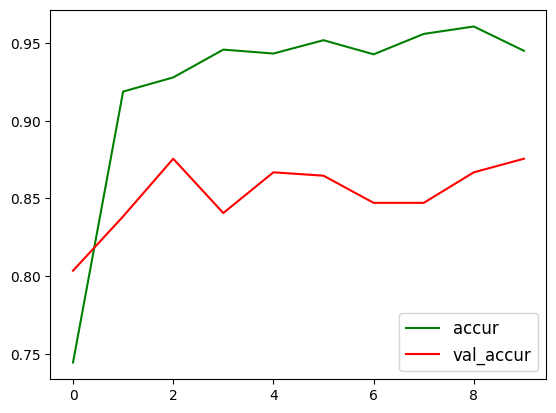

In [5]:

inputs = layers.Input(shape=(img_size, img_size, 3))
x = EfficientNetV2B0(include_top=False, weights='weights_v2b0_3L.h5',pooling='avg', include_preprocessing =  None,  input_shape = (224,224,3))(inputs) #include_preprocessing = False,
#x = keras.layers.Dropout(rate=0.2)(x)
output = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs,output)

model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=[keras.metrics.CategoricalAccuracy(name="acc_categ"), "accuracy"])#keras.metrics.CategoricalAccuracy(name="accuracy"),
model.summary()

his = model.fit(train_gen, epochs=10, validation_data=val_gen)#
#model.layers[1].save_weights('weights_v2b0_3L.h5') #Сохраняем веса

plt.plot(his.history['accuracy'],label = 'accur', color = 'green')
plt.plot(his.history['val_accuracy'],label = 'val_accur', color = 'red')
plt.legend(fontsize=12)
plt.show()

In [ ]:
from heapq import nlargest
image_test = cv2.imread('kit_2_mask.png')
image_test = [cv2.resize(image_test, (224, 224))]
image_test = np.array(image_test).astype('float32')/ 255.0

print(image_test.shape)
print(x_train[0].shape)

model.summary()
pred = model.predict(np.array(image_test))

[print(list(pred[0]).index(x)) for x in sorted(list(pred[0]))[-5:]]
print('\ncinid\n')
[print(x) for x in sorted(list(pred[0]))[-5:]]
#print(pred)
#print(y_train_non_categorical[544])

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, x_set, batch_size):
        self.x= x_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        #print(batch_x)
        #print(batch_y)
        return batch_x


inputs = layers.Input(shape=(img_size, img_size, 3))
output = EfficientNetV2B0(include_top=False, weights='weights_v2b0_3L.h5', pooling='avg',include_preprocessing = False,  input_shape = (224,224,3))(inputs)
model = keras.Model(inputs,output)

model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=["accuracy"])
model.summary()

data_gen = DataGenerator(x_train,8)

y_pred = model.predict(data_gen)


In [ ]:
X=y_pred
print(X.shape)
print(y_train_non_categorical.shape)

df = pd.DataFrame(data=y_train_non_categorical)
df.to_csv('disa.csv',index=False)



In [ ]:


 #аугментированные данные
data_list = []
for path_number in os.listdir('.\\test_autoenc'):
    image = cv2.imread('./test_autoenc/'+path_number)
    image = cv2.resize(image, (img_size, img_size))
    data_list.append(image)

x_test = np.array(data_list).astype('float32')/ 255.0
data_list = None
print('cinus')



In [20]:
from numpy import expand_dims

datagen = ImageDataGenerator(rotation_range=360,
                             horizontal_flip=True,
                             vertical_flip=True)

data_augment = []

for img in x_test:
    samples = expand_dims(img, 0)
    data_train_x = datagen.flow(samples, batch_size=8)
    for _ in range(2):
        batch = data_train_x.next()
        image = batch[0].astype('float32')
        #cv2.imshow('window_name', image)
        #cv2.waitKey(0)
        data_augment.append(image)

data_augment = np.array(data_augment).astype('float32')
print('cinus'*2)

print(data_augment.shape)

cinuscinus
(10680, 224, 224, 3)


In [29]:
x_test = None

def SSIMLoss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))



inputs  = keras.Input(shape=(224, 224, 3),name='input_layer')

# Conv Block 1 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs )
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_1')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_1')(encoded)
# Conv Block 2 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_2')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_2')(encoded)
# Conv Block 3 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_3')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_3')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_3')(encoded)

# DeConv Block 1-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(encoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_4')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_4')(decoded)
# DeConv Block 2-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_5')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_5')(decoded)
# DeConv Block 3-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_6')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_6')(decoded)

outputs = tf.keras.layers.Conv2DTranspose(3, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)



autoencoder = tf.keras.Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(lr = 0.0005)
#data_train_x = DataGenerator(x_train, x_train, 8)
#data_train_x = datagen.flow(x_train, batch_size = 8)


data_gen = DataGenerator(data_augment, data_augment, 8)



autoencoder = keras.models.load_model('autoencoder_full.h5', compile=False)
autoencoder.compile(optimizer=optimizer, loss=SSIMLoss)
autoencoder.fit(data_gen, epochs=10)
autoencoder.save('autoencoder_full_2.h5')

C:\Users\ykolt\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
1335/1335 [==============================] - 56s 40ms/step - loss: 0.0066
Epoch 2/10
1335/1335 [==============================] - 59s 44ms/step - loss: 0.0063
Epoch 3/10
1335/1335 [==============================] - 57s 43ms/step - loss: 0.0058
Epoch 4/10
1335/1335 [==============================] - 55s 41ms/step - loss: 0.0060
Epoch 5/10
1335/1335 [==============================] - 56s 42ms/step - loss: 0.0059
Epoch 6/10
1335/1335 [==============================] - 55s 41ms/step - loss: 0.0052
Epoch 7/10
1335/1335 [==============================] - 55s 41ms/step - loss: 0.0052
Epoch 8/10
1335/1335 [==============================] - 55s 41ms/step - loss: 0.0050
Epoch 9/10
1335/1335 [==============================] - 56s 42ms/step - loss: 0.0048
Epoch 10/10
1335/1335 [==============================] - 55s 41ms/step - loss: 0.0045


cinus


In [28]:
image_test_shack = cv2.imread('0.jpg')
image_test_shack  = [cv2.resize(image_test_shack , (224, 224))]
image_test_shack  = np.array(image_test_shack).astype('float32')/ 255.0

#print(image_test.shape)

num = 10
autoencoder_2 = keras.models.load_model('autoencoder_full.h5', compile=False)
autoencoder_2.compile(optimizer=optimizer, loss=SSIMLoss)

#autoencoder.summary()




#autoencoder.save('autoencoder.h5')

from PIL import ImageChops
from PIL import Image

def calcdiff(im1, im2):
    dif = ImageChops.difference(im1, im2)
    return np.mean(np.array(dif))


def anti_cinus(pred, image_test):
    if float(SSIMLoss(pred[0], image_test))>0.1:
        return True, float(SSIMLoss(pred[0], image_test))
    else:
        return False, float(SSIMLoss(pred[0], image_test))

'''
im_1 = Image.fromarray(pred[0], 'RGB')
im_2 = Image.fromarray(x_train[0], 'RGB')
'''

#print(calcdiff(im_1,im_2)) #чем меньше тем лучше
pred = autoencoder_2.predict(np.array(image_test_shack))
print('Изменённое изображение: ', float(SSIMLoss(pred[0], image_test_shack)))


log = []

'''
for i in range(len(x_test[:1])):
    #pred = autoencoder_2.predict(np.array([x_test[i]]))
    #cinus = float(SSIMLoss(pred[0], x_test[i]))
    #im_1 = Image.fromarray(pred[0], 'RGB')
    #im_2 = Image.fromarray(x_train[i], 'RGB')
    #print(cinus)

    flag, cinus = anti_cinus(autoencoder_2.predict(np.array([x_test[i]])), x_test[i])
    print( cinus)
    if flag==True:
        log.append('Index: '+str(i)+'\n'+'Ошибка: '+str(cinus))
        print('Index: ', i)
        print('Ошибка: ', cinus)

print(log)
'''

1/1 [==============================] - 1s 588ms/step
Изменённое изображение:  0.011387646198272705


"\nfor i in range(len(x_test[:1])):\n    #pred = autoencoder_2.predict(np.array([x_test[i]]))\n    #cinus = float(SSIMLoss(pred[0], x_test[i]))\n    #im_1 = Image.fromarray(pred[0], 'RGB')\n    #im_2 = Image.fromarray(x_train[i], 'RGB')\n    #print(cinus)\n\n    flag, cinus = anti_cinus(autoencoder_2.predict(np.array([x_test[i]])), x_test[i])\n    print( cinus)\n    if flag==True:\n        log.append('Index: '+str(i)+'\n'+'Ошибка: '+str(cinus))\n        print('Index: ', i)\n        print('Ошибка: ', cinus)\n\nprint(log)\n"

In [7]:
inputs = layers.Input(shape=(img_size, img_size, 3))
output = EfficientNetV2B0(weights='model_weights_v2.h5', include_preprocessing = False, classes=num_classes, input_shape = (224,224,3))(inputs)
output2 = EfficientNetB0(weights='model_weights_v1.h5', classes=num_classes, input_shape = (224,224,3))(inputs)
#model = keras.Model(inputs,output)
#model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=["accuracy"])

#model2 = keras.Model(inputs,output)
#model2.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=["accuracy"])

merged = tf.keras.layers.concatenate([output,output2], name="concatenated_model")
models = keras.Model(inputs=inputs, outputs=merged)
#models.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=["accuracy"])

model_stecing = keras.Sequential([
    models,
    Dense(32, activation="relu"),
    Dense(8, activation="softmax")
])

model_stecing.trainable = False
model_stecing.summary()
model_stecing.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=["accuracy"])

plot_model(model_stecing, to_file='demo.png',show_shapes=True)

his = model_stecing.fit(train_gen, epochs=10, validation_data=val_gen)
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.show()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_3 (Functional)        (None, 16)                9989379   
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 8)                 264       
                                                                 
Total params: 9,990,187
Trainable params: 0
Non-trainable params: 9,990,187
_________________________________________________________________
Epoch 1/10
281/281 [==============================] - 52s 142ms/step - loss: 2.0499 - accuracy: 0.0397 - val_loss: 2.0534 - val_accuracy: 0.0398
Epoch 2/10
281/281 [==============================] - 36s 129ms/step - loss: 2.0497 - accuracy: 0.0392 - val_loss: 2.0534 - val_accuracy: 0.0398
Epoch 3/10
281/281

KeyboardInterrupt: 

In [9]:
model.layers[1].save_weights('my_model_weights_v2.h5') #Сохраняем веса

In [7]:

y_test = pd.read_csv('test.csv')
data_list = []

for i in y_test['ID_img']:
    image = cv2.imread('./test/'+i)
    image = cv2.resize(image, (img_size, img_size))
    data_list.append(image)
#print(np.array(data_list))
x_test = np.array(data_list).astype('float32') / 255.0
y_pred = model.predict(x_test)
for i in range(y_test.shape[0]):
    y_test['class'][i] = np.argmax(y_pred[i])
#print(y_test)
y_test.to_csv('EfficientNetb0_imageGen.csv', index=False)

67/67 [==============================] - 8s 68ms/step


C:\Users\ykolt\AppData\Local\Temp\ipykernel_7020\491157149.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['class'][i] = np.argmax(y_pred[i])


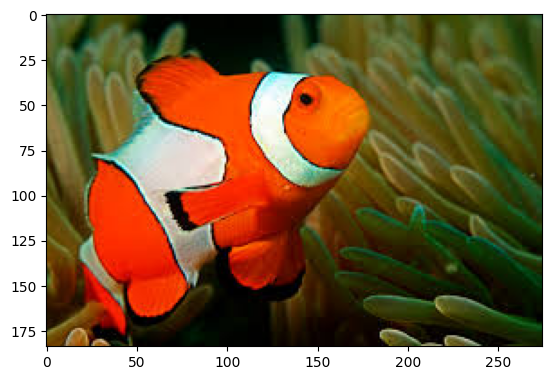

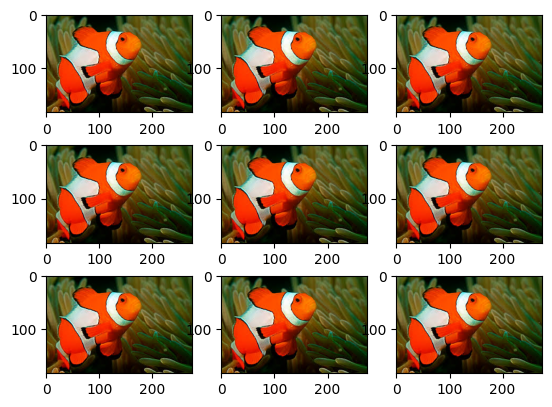

In [4]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
img = load_img('nemo0.jpg')
plt.imshow(img)
plt.show()

data = img_to_array(img)
samples = np.expand_dims(data, 0)
datagen = ImageDataGenerator(zca_epsilon=0.1)
it = datagen.flow(samples, batch_size=1)

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

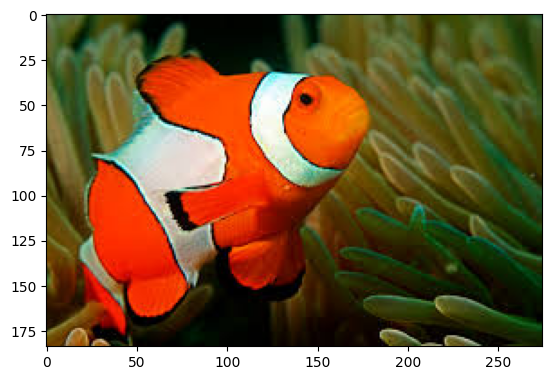

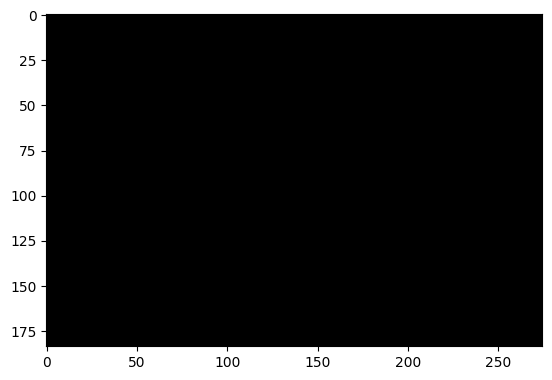

In [3]:
dark_color = (212.0000, 86.5385, 20.3922)#(7,28,52)
light_color =  (208.0000, 72.1154, 40.7843)#(29,69,104)



def segment_fish(image):
    ''' Cегментация рыбы-клоуна из предоставленного изображения '''
    # Конвертация изображения в HSV
    hsv_image = image #cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # Установка оранжевого диапазона
    light_orange = (255,204,153)#(1, 190, 200)
    dark_orange = (255,153,51)#(18, 255, 255)

    # Применение оранжевой маски
    mask = cv2.inRange(hsv_image, light_orange, dark_orange)
    # Установка белого диапазона
    light_white = (255,255,255)#(0, 0, 200)
    dark_white = (235,235,235)#(145, 60, 255)
    # Применение белой маски
    mask_white = cv2.inRange(hsv_image, light_white, dark_white)

    # Объединение двух масок
    final_mask = mask #+ mask_white
    result = cv2.bitwise_and(image, image, mask=final_mask)

    # Сглаживание сегментации с помощью размытия
    #blur = cv2.GaussianBlur(result, (7, 7), 0)
    return result

nemo = cv2.imread('nemo0.jpg')
nemo = cv2.cvtColor(nemo, cv2.COLOR_BGR2RGB)
plt.imshow(nemo)
plt.show()
seg = segment_fish(nemo)

plt.imshow(seg)
plt.show()